# Introduction to Machine Learning Exercise: Decision Trees and K-Means

In this notebook, you will learn about supervised and unsupervised machine learning models. In this version, you will learn about Decision Tress and K-Means as presented in the Lecture.

- You will be guided through the note step by step. 
- You can execute the cells in a sequential order to follow the storyline.
- We indicated **"Interactive Task"** throughout the notebook. These are parts, were you might need to do small adjustements to the code to see how the results change.
- However, feel free to also adjust and play around with other parts as you go along.

Let us start by importing all the libraries that we will need...

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import tree
import graphviz 

# Decision Trees

First, we learn how to apply decision tress while working on the "Titanic Challenge". More specifically, we use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The Titanic Challenge is a widely used common machine learning beginner challenge. It is also the getting started competition at [Kaggle](https://www.kaggle.com) - the online community of data scientists and machine learners. So, after working through this notebook, you can quickly work on your own, improved solution, join the Kaggle competition, and compare your results with the community - give it a try!

We are going to use the python library `scikit-learn`. Scikit-learn is built on NumPy, SciPy, and matplotlib and provides a range of supervised and unsupervised learning algorithms for classification, regression, and clustering. For more information about scikit-learn, click [here](https://scikit-learn.org/stable/). 

## Data

The file `titanic_data.csv` contains data from Titanic passengers with the following columns:

- PassengerId: unique identification number for each passenger
- Survived: 0 = No, 1 = Yes
- Pclass: the passenger class, 1 = 1st (upperclass), 2 = 2nd (middle class), 3 = 3rd (lower class)
- Name: full name of the passenger
- Sex: male or female
- Age: age of passenger in years, e.g. 22
- SibSp: number of siblings/ spouses aboard the Titanic
- Parch: number of parents/ children aboard the Titanic
- Ticket: ticket number
- Fare: passenger fare  
- Cabin: cabin number
- Embarked: port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

Let's import the data and have a closer look at it:

In [3]:
data_url = "http://people.aifb.kit.edu/zg2916/teaching/hector2020/titanic_data.csv"
titanic_data = pd.read_csv(data_url)
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
titanic_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


It is always essential to have a closer look at the data first. Here are some of the questions you may want to look at more precisely. 
- Are the features numeric or categorical?
- Which features may influence the prediction, and which not?
- Which features have to be proceeded? 
- Do we have missing entries? (NaN)
    
It is also a good idea to plot some of the features to generate a good understanding of the data and decide for further processing.

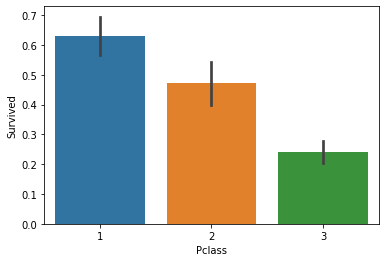

In [5]:
# Plot Class - Survived
sns.barplot(x='Pclass', y='Survived', data=titanic_data)

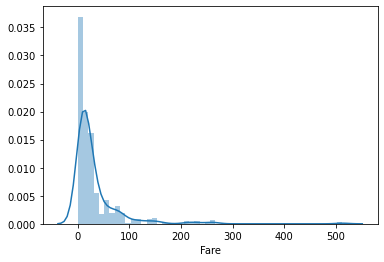

In [6]:
# Plot Fare Distribution
sns.distplot(titanic_data['Fare'])

In the graph above we can see that class influences the chance of survival.

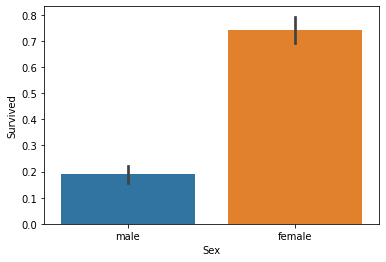

In [7]:
# Plot Sex - Survived
sns.barplot(x='Sex', y='Survived', data=titanic_data)

Also, gender impacts the chance of survival.

So the column `Survived` is our prediction target. For our first try, let's focus on the features `Pclass`, `Sex`, `Age`, `Fare` and `Embarked`. 

## Data Preprocessing

First, we have to drop the features we don't want to take into consideration for the prediction.
Here, we assume the following columns to have no predictive power:
- PassengerId
- Name
- SibSp (Sibling or Spouse Aboad)
- Parch (Number of parents/siblings aboard)
- Cabin
- Ticket (ID)

In [8]:
# Remove the columns from the dataframe
data = titanic_data.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Cabin', 'Ticket'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  889 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 41.9+ KB


Now we want to find out about missing entries in the remaining data:

In [9]:
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Sex,0,0.0
Pclass,0,0.0
Survived,0,0.0


As you can see, Age is missing 177 entries, and Embarked is missing 2 entries. We are going to fill the 2 missing entries of Embarked with the most common one and the 177 entires of Age with the average age.

In [10]:
# To find out the most common entry:
data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [11]:
# Fill missing values of Embarked with the most common entry
common_value = 'S'
data['Embarked'] = data['Embarked'].fillna(common_value)

In [13]:
# Fill missing values of Age with the mean Age

# Compute the mean age
mean = data['Age'].mean()

# Fill Na values
data['Age'] = data['Age'].fillna(mean)

### Interactive Task

- Can you think about other ways to handle missing values?

As we saw above in data.info(), we have different datatypes. We need to transform the categorical values of Sex and Embarked into numerical ones so that machine learning algorithms can process them. Furthermore, the features have different ranges that we need to convert into roughly the same scale. In our case, we need to categorize the feature Age.

In [14]:
#Sex
genders = {"male": 0, "female": 1}
data['Sex'] = data['Sex'].map(genders)

In [15]:
#Embarked
ports = {"S": 0, "C": 1, "Q": 2}
data['Embarked'] = data['Embarked'].map(ports)

Now we categorize Age and convert it from float to int. For the categorization, it is crucial to distribute the values, and not have 90 % of the data in one group.

In [16]:
# Age
data['Age'] = data['Age'].astype(int)
data.loc[ data['Age'] <= 11, 'Age'] = 0
data.loc[(data['Age'] > 11) & (data['Age'] <= 18), 'Age'] = 1
data.loc[(data['Age'] > 18) & (data['Age'] <= 22), 'Age'] = 2
data.loc[(data['Age'] > 22) & (data['Age'] <= 27), 'Age'] = 3
data.loc[(data['Age'] > 27) & (data['Age'] <= 33), 'Age'] = 4
data.loc[(data['Age'] > 33) & (data['Age'] <= 40), 'Age'] = 5
data.loc[(data['Age'] > 40) & (data['Age'] <= 66), 'Age'] = 6
data.loc[ data['Age'] > 66, 'Age'] = 7

In [17]:
# Let's check the distribution
data['Age'].value_counts()

4    303
6    141
3    106
5    103
2     92
1     71
0     68
7      7
Name: Age, dtype: int64

Finally, we have a last look at our data before getting started with ML:

In [18]:
data.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,0,2,7.2500,0
1,1,1,1,5,71.2833,1
2,1,3,1,3,7.9250,0
3,1,1,1,5,53.1000,0
4,0,3,0,5,8.0500,0
5,0,3,0,4,8.4583,2
6,0,1,0,6,51.8625,0
7,0,3,0,0,21.0750,0
8,1,3,1,3,11.1333,0
9,1,2,1,1,30.0708,1


## Split into Train and Test

Now we want to split the data into train and test data. There are many ways and methods to split the data. We will simply use a test size of 10 % of the data.

In [21]:
# We have to separate the target column first:
X = data.drop("Survived", axis=1)
y = data["Survived"]

# And split the data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Interactive Tasks:

- Try out other split ratios (`test_size` parameter) and see how the results of your model change. Let us start with a value of `0.1` and change it once we have investigated the results.

In [22]:
# Create the classifier object with a depth of "max_depth"
decision_tree = DecisionTreeClassifier(max_depth=3) 

# See here for reference: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html 
# There you can find also additional parameters

# Train the model using the training data
decision_tree.fit(X_train, y_train)  

# Compute the predictions for the testing data
y_pred = decision_tree.predict(X_test)  

## Confusion Matrix

We can get a first insight in the performance of the model by looking at the confusion matrix.
The confusion matrix combines the value for *True Positives (TP)*, *True Negatives (TN)*, *False Negatives (FN)* and *False Positives*.

Let us first define a function to compute these values based on the a given prediction.

In [23]:
# Function to compute TP, TN, FP, FN values
def confusion_matrix(y_test, y_pred):
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    #the true values:
    y_real = np.array(y_test)
    
    # For all predictions made
    for i in range(len(y_pred)):
        # True Positives
        if y_pred[i] == 1 and  y_real[i] == 1:
            tp += 1
            
        # True Negatives
        elif y_pred[i] == 0 and  y_real[i] == 0:
            tn += 1
        
        # False Positives
        elif y_pred[i] == 1 and  y_real[i] == 0:
            fp += 1
            
        # False Negative
        elif y_pred[i] == 0 and  y_real[i] == 1:
            fn += 1
    return tp, fp, fn, tn

We can now print the values for a given prediction on a test set.

In [24]:
tp, fp, fn, tn = confusion_matrix(y_test, y_pred)
print(f"True Positives shows how many passengers correctly classified as survived: {tp}")
print(f"True Negatives shows how many passengers correctly classified as dead: {tn}")
print(f"False Negatives shows how many passengers wrongly classified as dead: {fn}")
print(f"False Positives shows how many passengers wrongly classified as survived: {fp}")

True Positives shows how many passengers correctly classified as survived: 27
True Negatives shows how many passengers correctly classified as dead: 49
False Negatives shows how many passengers wrongly classified as dead: 8
False Positives shows how many passengers wrongly classified as survived: 6


As you can see, these values are all absolute values. As a result, the predicitions for different sizes of test sets are not comparable.
In order to get a better insight into the performance, we introduce the following metrics to get a better idea about the performance of the algorithm.

## Precision, Recall and F1 Score

Precision, recall and F1 Score are the commonly used evaluation metrics for classification task.
We can compute them based on the previously computed TP, TN, FN, and FP values using the following formulas:

$Precsion = \frac{TP}{(TP+FP)}$

$Recall = \frac{TP}{(TP+FN)}$

$F_1 = \frac{(2 * Precision * Recall)}{ (Precision + Recall)}$

### Interactive Task

- In the code box below, add the code to compute Precision, Recall and F1 Measure using the formulas

In [26]:
def precision(tp,tn,fp,fn):
    precision = 0 # ADD CODE HERE 
    return precision

def recall(tp,tn,fp,fn):
    recall = 0 # ADD CODE HERE 
    return recall

def f1(tp,tn,fp,fn):
    precision = 0 # ADD CODE HERE (Hint: reuse existing functions)
    recall = 0 # ADD CODE HERE (Hint: reuse existing functions)
    f1 = 0 # ADD CODE HERE 
    return f1

print('Precision:', round(precision(tp, fp, tn, fn),3))
print('Recall:', round(recall(tp, fp, tn, fn), 3))
print('F1:', round(f1(tp, fp, tn, fn), 3))

Precision: 0
Recall: 0
F1: 0


We can also use the formulas that are provided as part of the `sklearn` library to compute those values.

### Interactive Task:

- Check wehther the values you compute are identical to those using the library fromulas below.

In [27]:
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
f1_val = f1_score(y_test, y_pred)
print('Precision:', round(precision_val,3))
print('Recall:', round(recall_val, 3))
print('F1:', round(f1_val, 3))

Precision: 0.818
Recall: 0.771
F1: 0.794


We can now also visualize the results as bar plot.

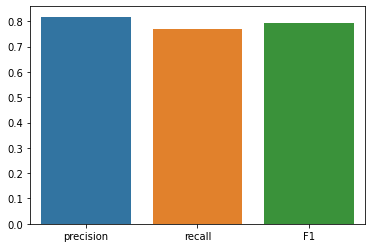

In [29]:
sns.barplot(x=["precision", "recall", "F1"], y=[precision_val, recall_val, f1_val])

## Visualize the Decision Tree

We want to get a better understanding of the decision trees and the rules that it has learned.
In order to do so, we can visualize the decision tree to inspect its decision rules.

Each node in the graph represents a decision rule. The nodes include information on:
- The feature
- The importance of the feature (as measured by the Gini Importance metric)
- The number of sample to which the rule was applied
- The values: How many sample fit into either class
- The class which would be predicited at the current point in the tree

### Interactive Tasks:

- Visualize the decision tree for different depth values. To do so, go back to the cell in which the decision tree is learned and change its parameter "max_depth" and re-run the cell
- Start with a small value and see how the complexity of the decision rules increase with increasing height.
- Check in the visualization which nodes are irrelevant for the classification.


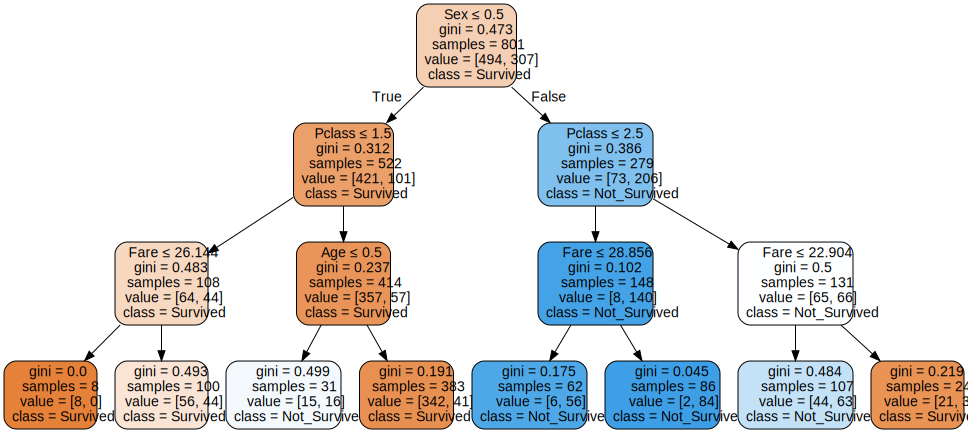

In [30]:
dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                     feature_names=['Pclass', 'Sex', 'Age', 'Fare', 'Embarked'],  
                     class_names=["Survived", "Not_Survived"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Interactive Tasks

After you inspected the decision trees and tried out different parameters, feel free to try the following changes as well:
- What happens when you use the actual age instead to the age-class for your predictions? (You will need to re-load the data and skip the step in which the age values are put into classes.)
- Do you think there are still features in the data that might not have a predictive power?
- What other feature can you think of, that could help the classification?
- Should precision and recall always be considered equally important? Can you think of cases where one or the other is more important?

# Clustering

After looking at a supervised learning approach to classify data, let us take a closer look at unsupervised learning.
In particular, we want to investigate data about customers of a mall.

Image you have selected different data about the customers that visit your mall using a survey.
Now you want to improve your sales and marketing strategy. In order to do so, you want to identfy different class/clusters of shoppers that are similar in their shopping behaviour.
In your survey, you have collected the following data:

- Gender
- Age
- Annual Income
- Spending Score (Relative score how much the customer spents when visit the mall)

Let us start by loading and checking out our data.

In [31]:
# First, we load the newdataset
data_url = "http://people.aifb.kit.edu/zg2916/teaching/hector2020/customer_data.csv"
customer_data = pd.read_csv(data_url)
customer_data = customer_data.set_index("CustomerID")
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


Good news: All customers complete filled out the surveys, so there are no `null` values which you need to handle.

Let us take a look at the data before we start our clustering.

In [32]:
customer_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


As previously, we should replace the non-numeric values for gender again and represent gender with a numeric value (0=Male, 1=Female)

In [33]:
genders = {"Male": 0, "Female": 1}
customer_data['Gender'] = customer_data['Gender'].map(genders)

## Visualize the data

Let us visualize the data to get some further insights into the distribution of the values. Maybe we can already see what potential customer clusters/segments can be.

Let us first check how the spending score and the income of the customers are related.

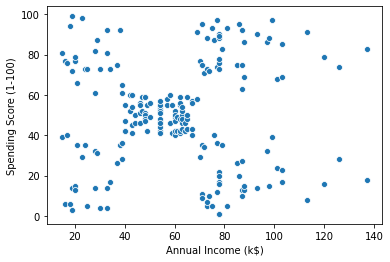

In [34]:
sns.scatterplot(x="Annual Income (k$)", y = "Spending Score (1-100)", data=customer_data)

We can also introduce a third dimension in our visulaization. For example, we can indicate the age of the customers using a color scale.

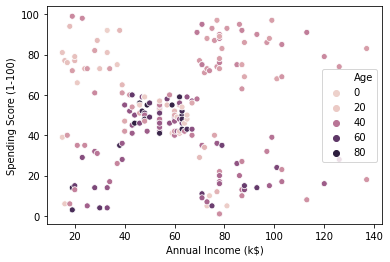

In [35]:
sns.scatterplot(x="Annual Income (k$)", y = "Spending Score (1-100)", hue="Age", data=customer_data) # Adding a hue for Age

After getting a first idea about the data, we want to cluster the customers.

For simplicity, let us consider the "income" and the "spending score" as our features to cluster the customers.
Since we K-Means is an unsupervised approach, we do not need to split our data into training and test datasets.

In [36]:
# Select data according to columns
X = customer_data[['Annual Income (k$)','Spending Score (1-100)']]
X_array = X.to_numpy()

## K-Means

After selecting the data, we can apply the K-Means clustering algorithm.

Even though K-Means is an unsupervised learning algorithm, we will need to specify how many clusters we want the algorithm to identify.
Let us start by trying 3 different clusters.

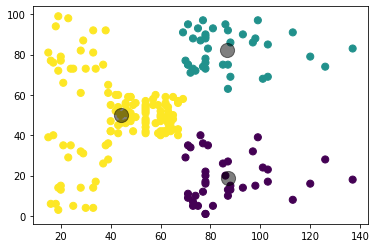

In [37]:
# Cluster the data
kmeans = KMeans(3, init='random') #, n_init=1, max_iter=1)

# Get Cluster labels to color data in the plot
labels = kmeans.fit_predict(X_array)

# Get the coordinates of the cluster centers
centers = kmeans.cluster_centers_

# Plot the data points and use the cluster labels to color the data 
plt.scatter(X_array[:, 0], X_array[:, 1], c=labels,
            s=50, cmap='viridis');

# Plot the Centers of the clutsers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=.5)

### Interactive tasks

- Try out different number of clusters and check how the clusters changes
- What do you think would be a good number of clusters and why? Think about what the data represents and what clusters you would expect in the data?
- Once you have clustered your customers, how could you make use of this information? (Think about sales and marketing strategies)

### Initialization steps

The K-Means algorithm starts by initializing random cluster centers. 
We can also visualize these initial steps by allowing the algorithm to perform only one iteration (Guessing centers and compute the inertia).


### Interactive tasks

- Re-run the following cell to see how the random initial state of the algorithm changes.
- Increase the `max_iter` parameter to allow the algorithm to execute more iterations. After how many iterations does the algorithm converge regardless of its inital state?

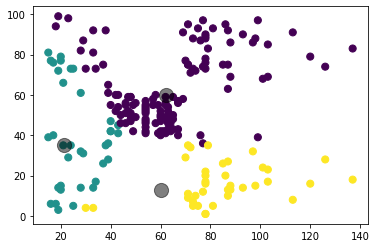

In [38]:
# Cluster the data
kmeans = KMeans(3, init='random', n_init=1, max_iter=1)

# Get Cluster labels to color data in the plot
labels = kmeans.fit_predict(X_array)

# Get the coordinates of the cluster centers
centers = kmeans.cluster_centers_

# Plot the data points and use the cluster labels to color the data 
plt.scatter(X_array[:, 0], X_array[:, 1], c=labels,
            s=50, cmap='viridis');

# Plot the Centers of the clutsers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=.5)